<a href="https://colab.research.google.com/github/alexgirmag/Predicting-Emergency-Department-Mortality-Risk-Using-Machine-Learning-Algorithms/blob/main/KNN_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing necessary libraries and pre-prosessed data

## Importing necessary libraries

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import randint, uniform

# Scikit-learn: Models & Multioutput
from sklearn.neighbors import KNeighborsClassifier

# Scikit-learn: Preprocessing & Composition
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

# Scikit-learn: Model Selection & Metrics
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.experimental import enable_halving_search_cv  # Required for HalvingGridSearchCV
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import make_scorer, f1_score, accuracy_score

# Imbalanced-learn: Pipeline & Sampling
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN, SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

## Importing pre-prosessed data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path1 =  "/content/drive/MyDrive/Splited_X_train.xlsx"

In [ ]:
file_path2 =  "/content/drive/MyDrive/Splited_X_test.xlsx"

In [ ]:
file_path3 =  "/content/drive/MyDrive/Splited_y_train.xlsx"

In [ ]:
file_path4 =  "/content/drive/MyDrive/Splited_y_test.xlsx"

In [ ]:
X_train2 = pd.read_excel(file_path1)

In [ ]:
X_test2 = pd.read_excel(file_path2)

In [ ]:
y_train = pd.read_excel(file_path3)

In [ ]:
y_test = pd.read_excel(file_path4)

In [ ]:
print(X_train2.shape)
print(X_test2.shape)
print(y_train.shape)
print(y_test.shape)

(7063, 23)
(1766, 23)
(7063, 1)
(1766, 1)


In [ ]:
print(X_train2.columns)

Index(['Metabolic_Case', 'Oncologic_Case', 'Age_group',
       'Mean Arterial Pressure', 'Triage color', 'Respiratory Rate',
       'PCA_Oxygen Delivery Index', 'White Blood Cells', 'Basophils',
       'Eosinophils', 'Platelets', 'Heart Rate', 'Gender_Male',
       'Visit type_repeat', 'Cardiovascular_Case', 'Gastrointestinal_Case',
       'Mean Corpuscular Volume', 'Red Cell Distribution Width',
       'Triage Waiting Time', 'Infectious_Case', 'Case Category_medical',
       'Case Category_surgical', 'Case Category_trauma'],
      dtype='object')


# Modularize Evaluation and Plotting

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc,
    precision_recall_curve,
    f1_score
)
import numpy as np

def evaluate_model_performance(y_true, y_pred, y_proba, model_name="Model"):
    """
    Evaluates a classification model and generates various plots.

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        y_proba (array-like): Predicted probabilities for the positive class.
        model_name (str): Name of the model for display in plots and reports.
    """

    print(f"\n{'='*20} Evaluation for {model_name} {'='*20}")

    # 1. Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['alive (0)', 'Died (1)']))

    # 2. Confusion Matrix with Specificity
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Calculate specificity
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    print(f"Specificity (True Negative Rate): {specificity:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Alive', 'Predicted Died'],
                yticklabels=['Actual Alive', 'Actual Died'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.show()

    # 3. AUC-ROC Curve
    roc_auc = roc_auc_score(y_true, y_proba)
    print(f"\nROC-AUC Score: {roc_auc:.4f}")

    # Plot ROC curve
    fpr, tpr, thresholds_roc = roc_curve(y_true, y_proba)
    roc_auc_plot = auc(fpr, tpr)

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc_plot:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Recall/Sensitivity)')
    plt.title(f'{model_name} - Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # 4. Precision-Recall Curve with Optimal Threshold
    precision, recall, thresholds_pr = precision_recall_curve(y_true, y_proba)
    pr_auc = auc(recall, precision)
    print(f"PR-AUC Score: {pr_auc:.4f}")

    # Calculate F1-scores for each threshold
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6) # Avoid division by zero

    # Find the optimal threshold (max F1-score)
    # Note: thresholds_pr has one less element than precision/recall, so we align indices
    optimal_idx = np.argmax(f1_scores[:-1]) # Exclude the last element of f1_scores for threshold alignment
    optimal_threshold = thresholds_pr[optimal_idx]
    optimal_precision = precision[optimal_idx]
    optimal_recall = recall[optimal_idx]

    plt.figure(figsize=(8,6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR Curve (AUC = {pr_auc:.2f})')
    plt.scatter(optimal_recall, optimal_precision, color='red', s=100,
                label=f'Optimal Point (Threshold = {optimal_threshold:.2f})\nPrecision = {optimal_precision:.2f}, Recall = {optimal_recall:.2f}')
    plt.xlabel('Recall (Sensitivity)')
    plt.ylabel('Precision (PPV)')
    plt.title(f'{model_name} - Precision-Recall Curve with Optimal Threshold')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    # 5. Classification Report and Confusion Matrix at Optimal Threshold
    y_pred_optimal = (y_proba >= optimal_threshold).astype(int)
    print(f"\nClassification Report at Optimal Threshold ({optimal_threshold:.2f}):")
    print(classification_report(y_true, y_pred_optimal, target_names=['Alive', 'Died']))

    cm_optimal = confusion_matrix(y_true, y_pred_optimal)
    tn_opt, fp_opt, fn_opt, tp_opt = cm_optimal.ravel()
    specificity_optimal = tn_opt / (tn_opt + fp_opt) if (tn_opt + fp_opt) != 0 else 0
    print(f"Confusion Matrix at Optimal Threshold:\n{cm_optimal}")
    print(f"Specificity (True Negative Rate) at Optimal Threshold: {specificity_optimal:.4f}")

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Alive', 'Predicted Died'],
                yticklabels=['Actual Alive', 'Actual Died'])
    plt.title(f"{model_name} - Confusion Matrix (Optimal Threshold = {optimal_threshold:.2f})")
    plt.show()
    print(f"\n{'='*60}")


In [ ]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)

In [ ]:
f1_scorer = make_scorer(f1_score, average='binary', pos_label=1)

# Train model Before Balancing

##Before Balancing And Tuning

**Training**

In [ ]:

model_1 = KNeighborsClassifier(
    n_neighbors=5,
    weights='uniform',
    metric='minkowski',
    p=2
)

In [ ]:

model_1.fit(X_train2, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

**Prediction**

In [ ]:

y_pred1 = model_1.predict(X_test2)
y_proba1 = model_1.predict_proba(X_test2)[:, 1]

**Evaluation**


==================== Evaluation for model_1 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.92      0.99      0.96      1581
    Died (1)       0.85      0.28      0.42       185

    accuracy                           0.92      1766
   macro avg       0.89      0.64      0.69      1766
weighted avg       0.91      0.92      0.90      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.9943


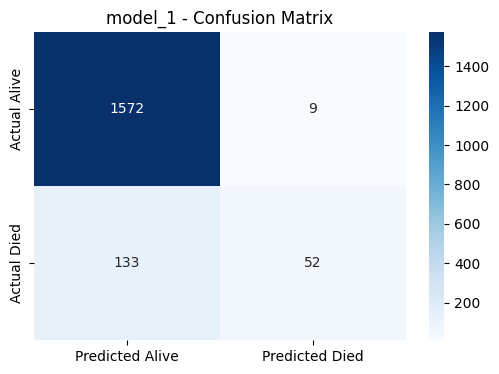


ROC-AUC Score: 0.7351


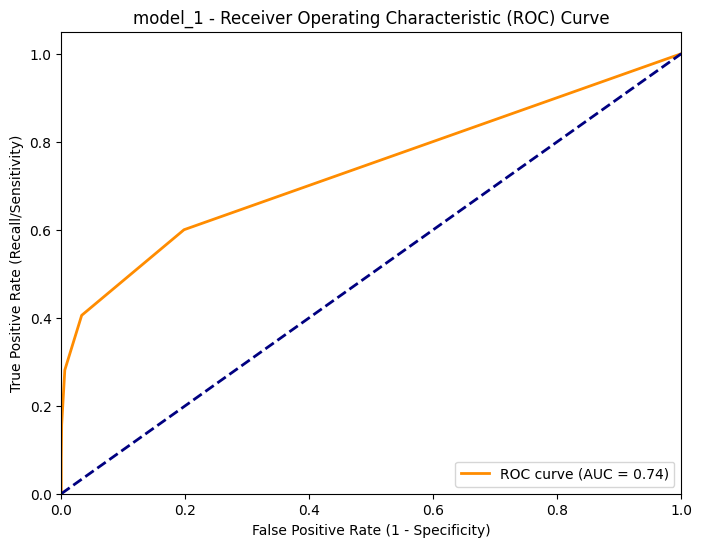

PR-AUC Score: 0.5145


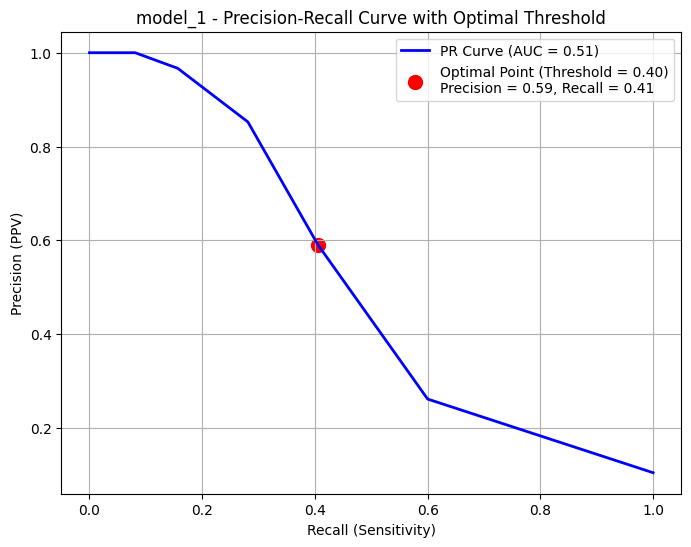


Classification Report at Optimal Threshold (0.40):
              precision    recall  f1-score   support

       Alive       0.93      0.97      0.95      1581
        Died       0.59      0.41      0.48       185

    accuracy                           0.91      1766
   macro avg       0.76      0.69      0.72      1766
weighted avg       0.90      0.91      0.90      1766

Confusion Matrix at Optimal Threshold:
[[1529   52]
 [ 110   75]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9671


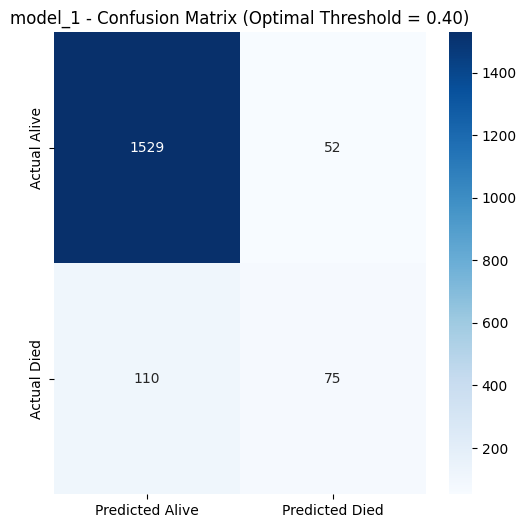

In [ ]:
evaluate_model_performance(y_test, y_pred1, y_proba1, model_name="model_1")

## Hyperparameter Tuning: RandomizedSearchCV

**Training**

In [ ]:
param_dist = {
    'n_neighbors': randint(3, 20),  # Smaller, more practical range
    'weights': ['uniform', 'distance'],
    'p': [1, 2],  # Just Manhattan (1) and Euclidean (2)
    'metric': ['minkowski']  # Default metric (covers p=1/2)
}

In [ ]:
knn_rs = RandomizedSearchCV(
    estimator=model_1,
    param_distributions=param_dist,
    n_iter=20,
    refit=True,
    n_jobs=-1,
    cv=cv,
    random_state=123,
    verbose=1
)

In [ ]:

print("Starting randomized search for medical data...")
knn_rs.fit(X_train2, y_train.values.ravel())  # Ensure y is 1D array

Starting randomized search for medical data...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=123, shuffle=True),
                   estimator=KNeighborsClassifier(), n_iter=20, n_jobs=-1,
                   param_distributions={'metric': ['minkowski'],
                                        'n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x79c92cff4e90>,
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   random_state=123, verbose=1)

In [ ]:

print("Best parameters found: ", knn_rs.best_params_)
print("Best F1 score: ", knn_rs.best_score_)

Best parameters found:  {'metric': 'minkowski', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
Best F1 score:  0.920288425056566


In [ ]:
best_model_rs = knn_rs.best_estimator_
best_model_rs.fit(X_train2, y_train)  # No eval_set here

/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(p=1)

**Prediction**

In [ ]:

y_pred2 = best_model_rs.predict(X_test2)
y_proba2 = best_model_rs.predict_proba(X_test2)[:, 1]

**Evaluation**


==================== Evaluation for model_2 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.92      0.99      0.96      1581
    Died (1)       0.88      0.31      0.46       185

    accuracy                           0.92      1766
   macro avg       0.90      0.65      0.71      1766
weighted avg       0.92      0.92      0.91      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.9949


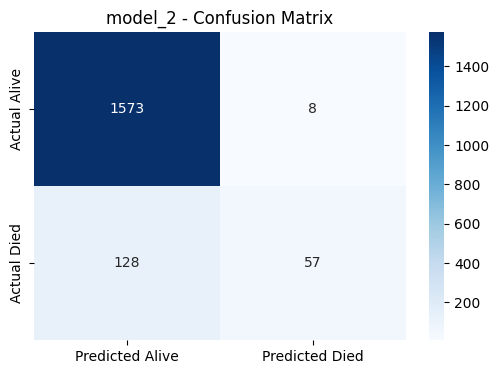


ROC-AUC Score: 0.7477


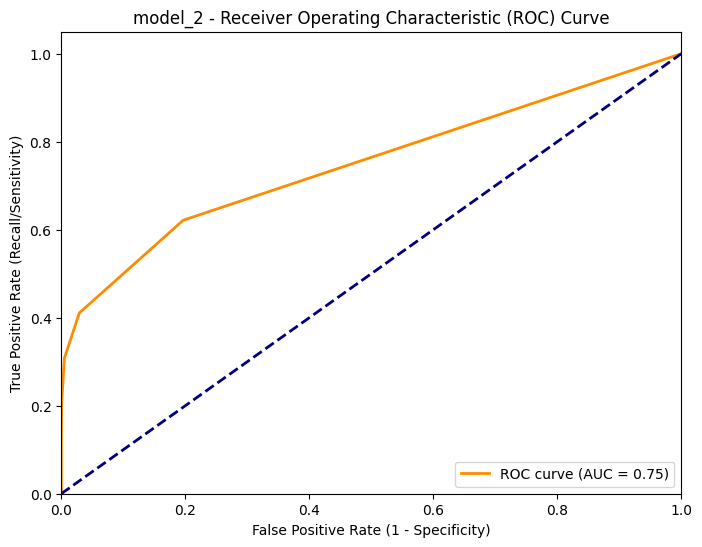

PR-AUC Score: 0.5413


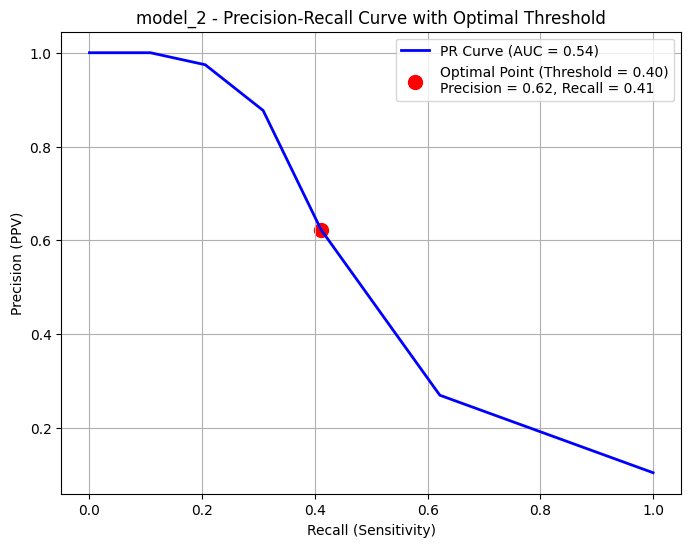


Classification Report at Optimal Threshold (0.40):
              precision    recall  f1-score   support

       Alive       0.93      0.97      0.95      1581
        Died       0.62      0.41      0.50       185

    accuracy                           0.91      1766
   macro avg       0.78      0.69      0.72      1766
weighted avg       0.90      0.91      0.90      1766

Confusion Matrix at Optimal Threshold:
[[1535   46]
 [ 109   76]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9709


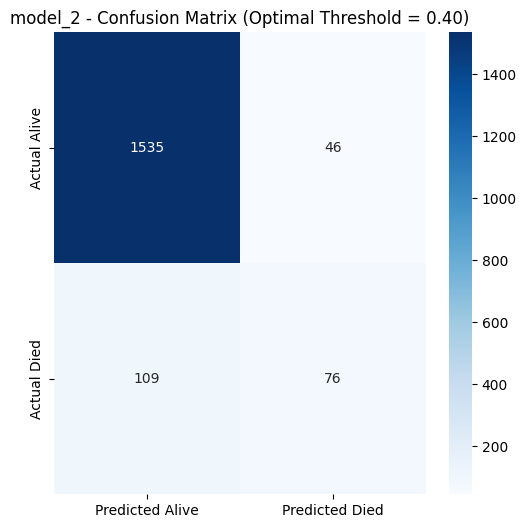

In [ ]:
evaluate_model_performance(y_test, y_pred2, y_proba2, model_name="model_2")

## Hyperparameter Tuning: Grid Search (GS)

**Training**

In [ ]:

param_grid = {
    'n_neighbors': [5, 7, 10, 15],
    'weights': ['distance'],
    'p': [1],
    'metric': ['minkowski']
}



In [ ]:

knn_gs = GridSearchCV(
    estimator= model_1,
    param_grid=param_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

In [ ]:

print("Starting exhaustive grid search for medical KNN...")
knn_gs.fit(X_train2, y_train.values.ravel())

Starting exhaustive grid search for medical KNN...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=123, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['minkowski'], 'n_neighbors': [5, 7, 10, 15],
                         'p': [1], 'weights': ['distance']},
             scoring='f1', verbose=1)

In [ ]:

print("Best parameters found: ", knn_gs.best_params_)
print("Best F1 score: ", knn_gs.best_score_)

Best parameters found:  {'metric': 'minkowski', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Best F1 score:  0.4172368329204282


In [ ]:
best_model_gs = knn_gs.best_estimator_
best_model_gs.fit(X_train2, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(p=1, weights='distance')

**Prediction**

In [ ]:

y_pred3 = best_model_gs.predict(X_test2)
y_proba3 = best_model_gs.predict_proba(X_test2)[:, 1]

**Evaluation**


==================== Evaluation for model_3 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.93      0.99      0.96      1581
    Died (1)       0.78      0.32      0.46       185

    accuracy                           0.92      1766
   macro avg       0.85      0.66      0.71      1766
weighted avg       0.91      0.92      0.90      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.9892


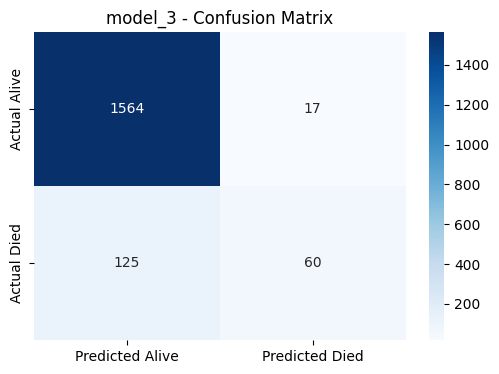


ROC-AUC Score: 0.7448


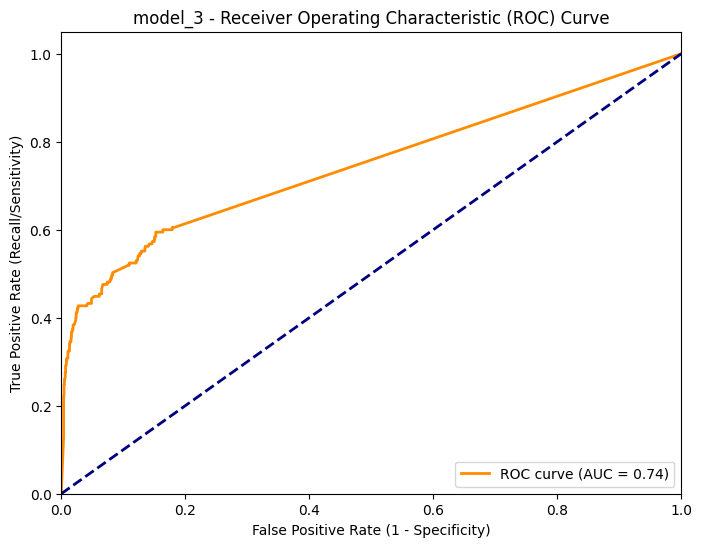

PR-AUC Score: 0.4956


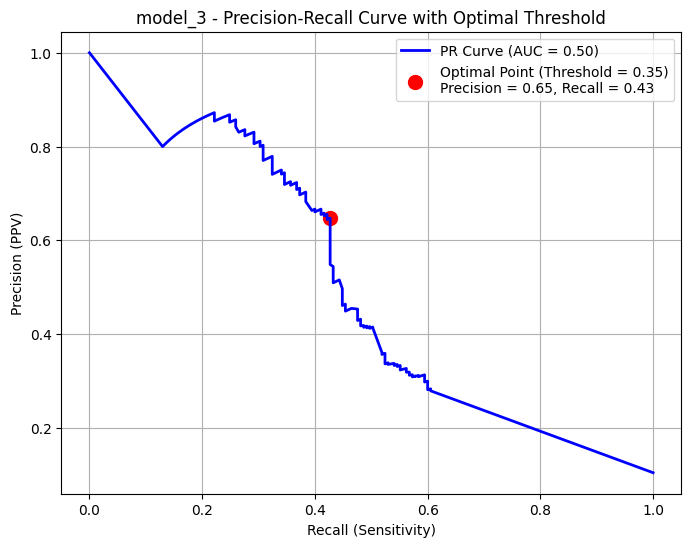


Classification Report at Optimal Threshold (0.35):
              precision    recall  f1-score   support

       Alive       0.94      0.97      0.95      1581
        Died       0.65      0.43      0.51       185

    accuracy                           0.92      1766
   macro avg       0.79      0.70      0.73      1766
weighted avg       0.91      0.92      0.91      1766

Confusion Matrix at Optimal Threshold:
[[1538   43]
 [ 106   79]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9728


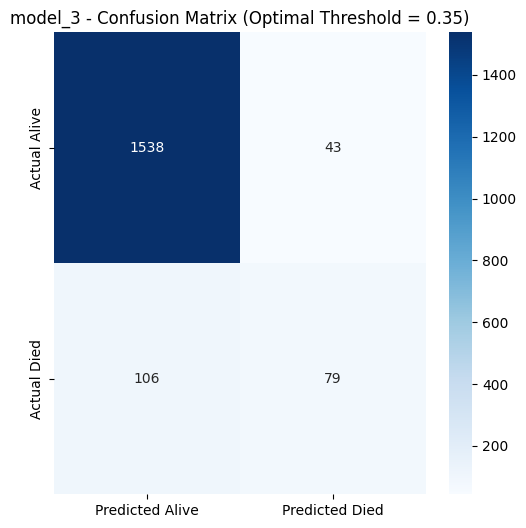

In [ ]:
evaluate_model_performance(y_test, y_pred3, y_proba3, model_name="model_3")

# Train the model after Balancing using SMOTE

##SMOT Only

**Training**

In [ ]:

knn_os = make_pipeline(
    SMOTE(random_state=123),
    model_1
)


In [ ]:
knn_os.fit(X_train2, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Pipeline(steps=[('smote', SMOTE(random_state=123)),
                ('kneighborsclassifier', KNeighborsClassifier())])

**Prediction**

In [ ]:

y_os_pred1 = knn_os.predict(X_test2)
y_os_proba1 = knn_os.predict_proba(X_test2)[:, 1]

**Evaluation**


==================== Evaluation for model_4 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.94      0.88      0.91      1581
    Died (1)       0.35      0.54      0.42       185

    accuracy                           0.85      1766
   macro avg       0.65      0.71      0.67      1766
weighted avg       0.88      0.85      0.86      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.8824


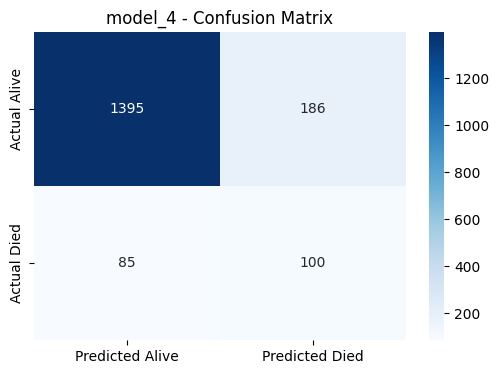


ROC-AUC Score: 0.7470


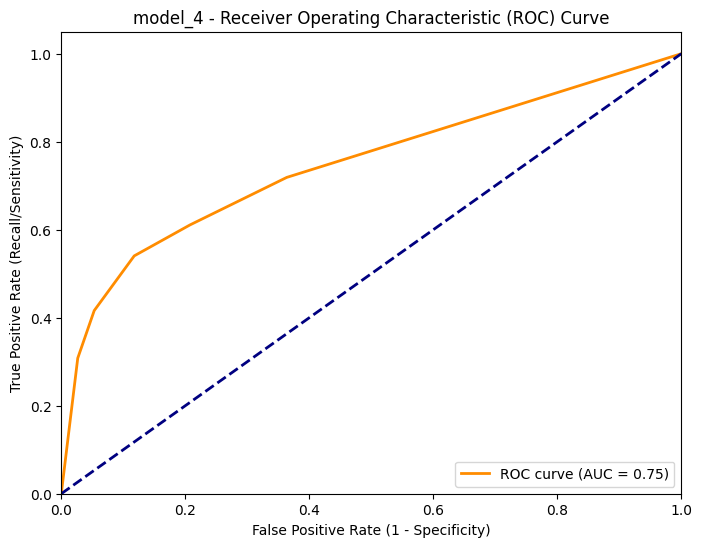

PR-AUC Score: 0.4376


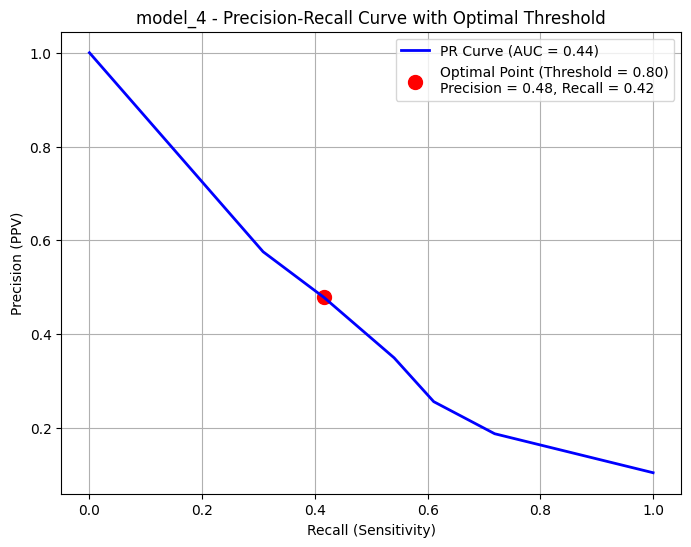


Classification Report at Optimal Threshold (0.80):
              precision    recall  f1-score   support

       Alive       0.93      0.95      0.94      1581
        Died       0.48      0.42      0.45       185

    accuracy                           0.89      1766
   macro avg       0.71      0.68      0.69      1766
weighted avg       0.89      0.89      0.89      1766

Confusion Matrix at Optimal Threshold:
[[1497   84]
 [ 108   77]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9469


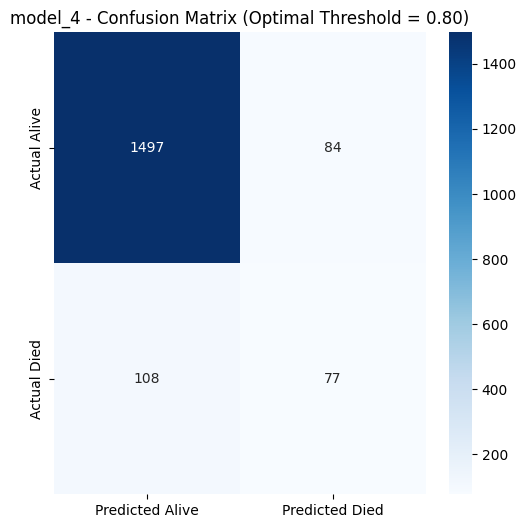

In [ ]:
evaluate_model_performance(y_test, y_os_pred1, y_os_proba1, model_name="model_4")

## SMOTE + RandomizedSearchCV

**Training**

In [ ]:
param_dist = {
    'smote__k_neighbors': randint(3, 7),
    'kneighborsclassifier__n_neighbors': randint(3, 25),
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__p': [1, 2],
    'kneighborsclassifier__metric': ['minkowski', 'cosine', 'manhattan'],
    'kneighborsclassifier__leaf_size': randint(20, 50),
    'kneighborsclassifier__algorithm': ['auto', 'ball_tree', 'kd_tree']
}

In [ ]:

knn_os_rs = RandomizedSearchCV(
    estimator=knn_os,
    param_distributions=param_dist,
    n_iter=50,
    cv=cv,
    scoring='roc_auc',
    refit=True,
    n_jobs=-1,
    random_state=123
)

In [ ]:
# Run the search
knn_os_rs.fit(X_train2, y_train.values.ravel())

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
30 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/imblearn/pipeline.py", line 522, in fit
    self._final_estimator.fit(Xt, yt, *

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=123, shuffle=True),
                   estimator=Pipeline(steps=[('smote', SMOTE(random_state=123)),
                                             ('kneighborsclassifier',
                                              KNeighborsClassifier())]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'kneighborsclassifier__algorithm': ['auto',
                                                                            'ball_tree',
                                                                            'kd_tree'],
                                        'kneighborsclassifier__leaf_size': <scipy.stats._distn_...
                                                                         'cosine',
                                                                         'manhattan'],
                                        'kneighborsclassifier__n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x79c92d0057f0>,
                                        'kneighborsclassifier__p': [1, 2],
                                        'kneighborsclassifier__weights': ['uniform',
                                                                          'distance'],
                                        'smote__k_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x79c92d035340>},
                   random_state=123, scoring='roc_auc')

In [ ]:

print("Best parameters found: ", knn_os_rs.best_params_)
print("Best F1 score: ", knn_os_rs.best_score_)

Best parameters found:  {'kneighborsclassifier__algorithm': 'kd_tree', 'kneighborsclassifier__leaf_size': 41, 'kneighborsclassifier__metric': 'minkowski', 'kneighborsclassifier__n_neighbors': 24, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'distance', 'smote__k_neighbors': 4}
Best F1 score:  0.7709282355158408


In [ ]:
best_knn_os_rs = knn_os_rs.best_estimator_
best_knn_os_rs.fit(X_train2, y_train)  # No eval_set here

/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Pipeline(steps=[('smote', SMOTE(k_neighbors=4, random_state=123)),
                ('kneighborsclassifier',
                 KNeighborsClassifier(algorithm='kd_tree', leaf_size=41,
                                      n_neighbors=24, p=1,
                                      weights='distance'))])

**Prediction**

In [ ]:

y_os_pred2 = best_knn_os_rs.predict(X_test2)
y_os_proba2 = best_knn_os_rs.predict_proba(X_test2)[:, 1]

**Evaluation**


==================== Evaluation for model_5 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.94      0.86      0.90      1581
    Died (1)       0.32      0.57      0.41       185

    accuracy                           0.83      1766
   macro avg       0.63      0.71      0.66      1766
weighted avg       0.88      0.83      0.85      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.8602


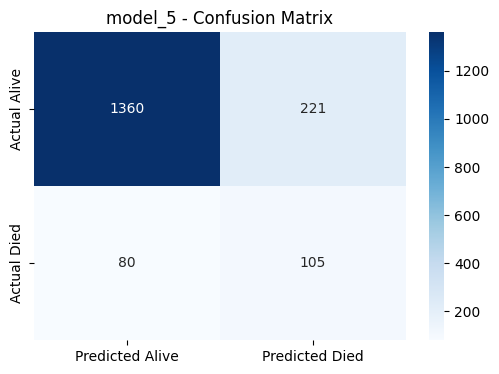


ROC-AUC Score: 0.7569


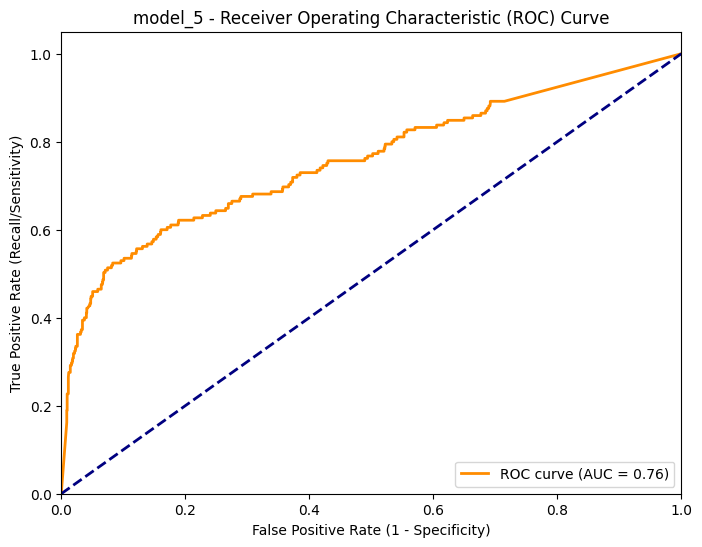

PR-AUC Score: 0.4458


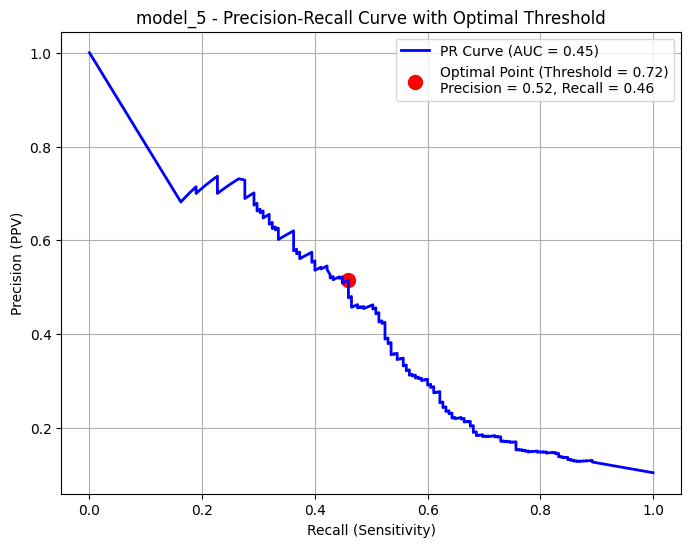


Classification Report at Optimal Threshold (0.72):
              precision    recall  f1-score   support

       Alive       0.94      0.95      0.94      1581
        Died       0.52      0.46      0.49       185

    accuracy                           0.90      1766
   macro avg       0.73      0.70      0.71      1766
weighted avg       0.89      0.90      0.90      1766

Confusion Matrix at Optimal Threshold:
[[1501   80]
 [ 100   85]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9494


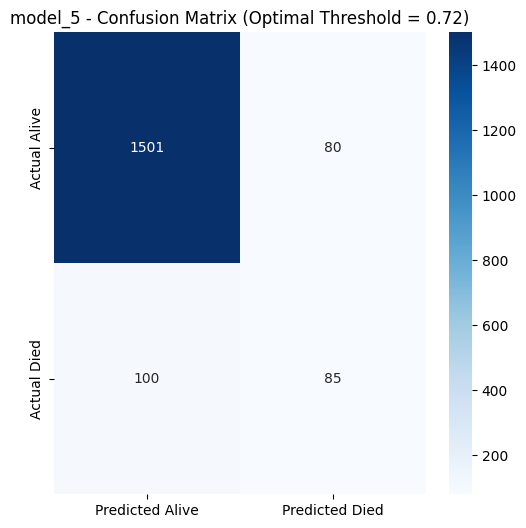

In [ ]:
evaluate_model_performance(y_test, y_os_pred2, y_os_proba2, model_name="model_5")

## SMOTE + GridSearchCV

**Training**

In [ ]:
param_grid = {
    'kneighborsclassifier__n_neighbors': [5, 7, 10, 15],
    'kneighborsclassifier__weights': ['distance'],
    'kneighborsclassifier__p': [1],
    'kneighborsclassifier__metric': ['minkowski']
}

In [ ]:

knn_os_gs = GridSearchCV(
    estimator=knn_os,
    param_grid=param_grid,
    scoring=f1_scorer,
    refit='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

In [ ]:

knn_os_gs.fit(X_train2, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=123, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=123)),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__metric': ['minkowski'],
                         'kneighborsclassifier__n_neighbors': [5, 7, 10, 15],
                         'kneighborsclassifier__p': [1],
                         'kneighborsclassifier__weights': ['distance']},
             refit='f1',
             scoring=make_scorer(f1_score, response_method='predict', average=binary, pos_label=1),
             verbose=1)

In [ ]:

print("Best parameters found: ", knn_os_gs.best_params_)
print("Best F1 score: ", knn_os_gs.best_score_)

Best parameters found:  {'kneighborsclassifier__metric': 'minkowski', 'kneighborsclassifier__n_neighbors': 5, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'distance'}
Best F1 score:  0.39522228675240445


In [ ]:
best_knn_smote_gs = knn_os_gs.best_estimator_
best_knn_smote_gs.fit(X_train2, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Pipeline(steps=[('smote', SMOTE(random_state=123)),
                ('kneighborsclassifier',
                 KNeighborsClassifier(p=1, weights='distance'))])

**Prediction**

In [ ]:

y_os_pred3 = best_knn_smote_gs.predict(X_test2)
y_os_proba3 = best_knn_smote_gs.predict_proba(X_test2)[:, 1]

**Evaluation**


==================== Evaluation for model_6 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.95      0.89      0.92      1581
    Died (1)       0.38      0.56      0.45       185

    accuracy                           0.86      1766
   macro avg       0.66      0.73      0.69      1766
weighted avg       0.89      0.86      0.87      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.8944


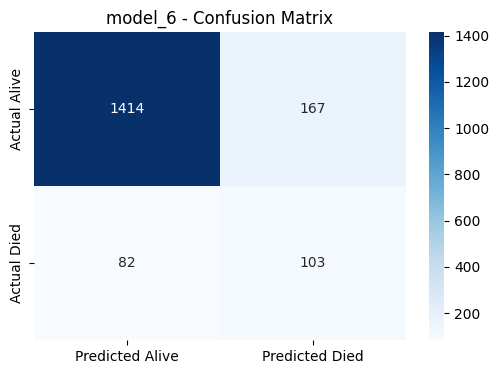


ROC-AUC Score: 0.7577


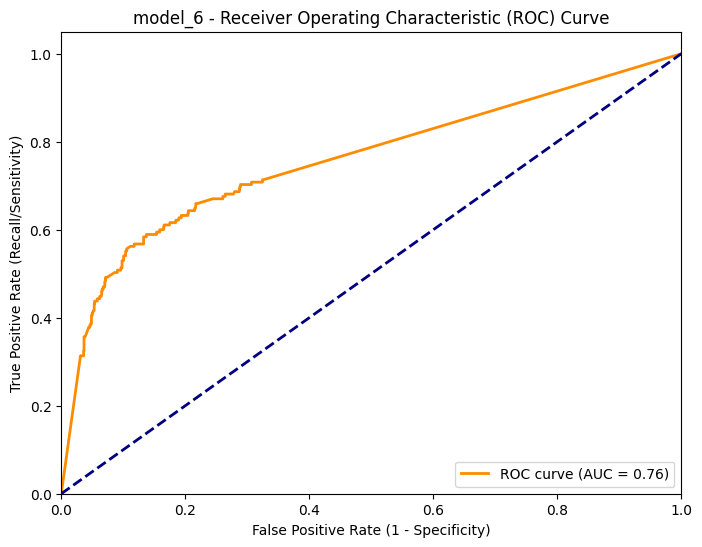

PR-AUC Score: 0.4412


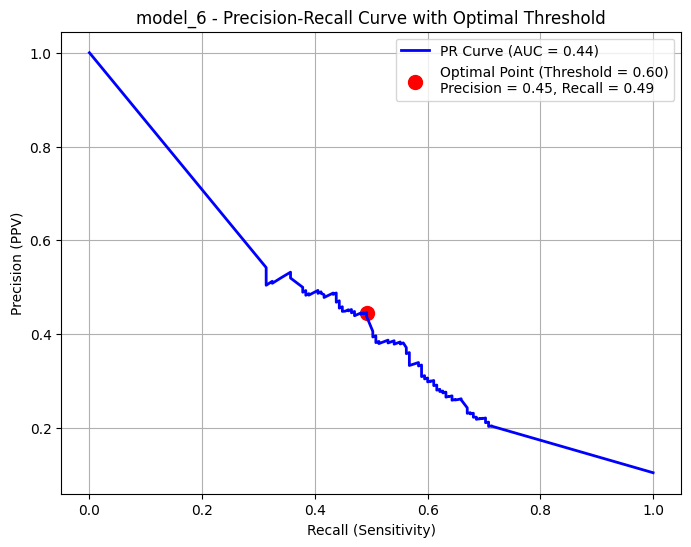


Classification Report at Optimal Threshold (0.60):
              precision    recall  f1-score   support

       Alive       0.94      0.93      0.93      1581
        Died       0.45      0.49      0.47       185

    accuracy                           0.88      1766
   macro avg       0.69      0.71      0.70      1766
weighted avg       0.89      0.88      0.89      1766

Confusion Matrix at Optimal Threshold:
[[1468  113]
 [  94   91]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9285


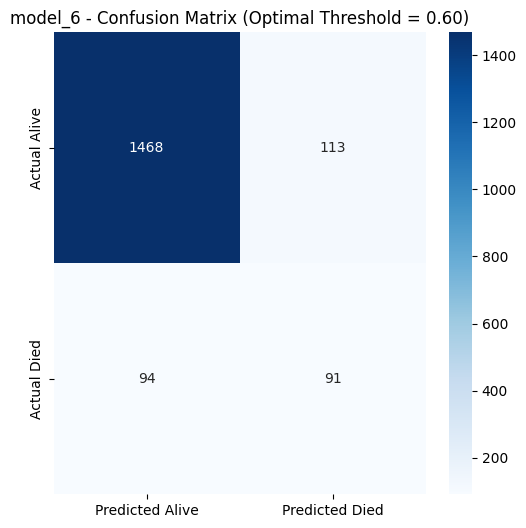

In [ ]:
evaluate_model_performance(y_test, y_os_pred3, y_os_proba3, model_name="model_6")

# Train the model after Balancing using undersampling

##Undersampling Only

**Training**

In [ ]:
# Minimal KNN with undersampling
knn_us = make_pipeline(
    RandomUnderSampler(random_state=123),
    model_1
)


In [ ]:
# training and evaluation
knn_us.fit(X_train2, y_train.values.ravel())
y_pred = knn_us.predict(X_test2)

**Prediction**

In [ ]:
# Generate predictions and probabilities
y_us_pred1 = knn_us.predict(X_test2)
y_us_proba1 = knn_us.predict_proba(X_test2)[:, 1]

**Evaluation**


==================== Evaluation for model_7 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.94      0.90      0.92      1581
    Died (1)       0.39      0.55      0.45       185

    accuracy                           0.86      1766
   macro avg       0.67      0.72      0.69      1766
weighted avg       0.89      0.86      0.87      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.8975


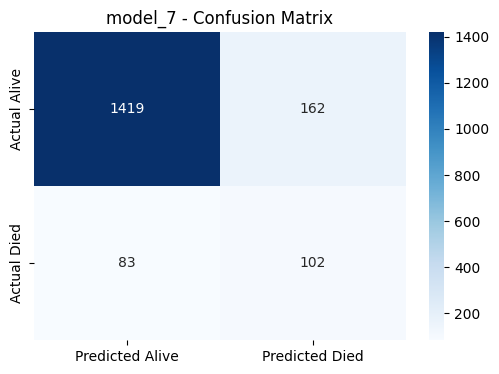


ROC-AUC Score: 0.7633


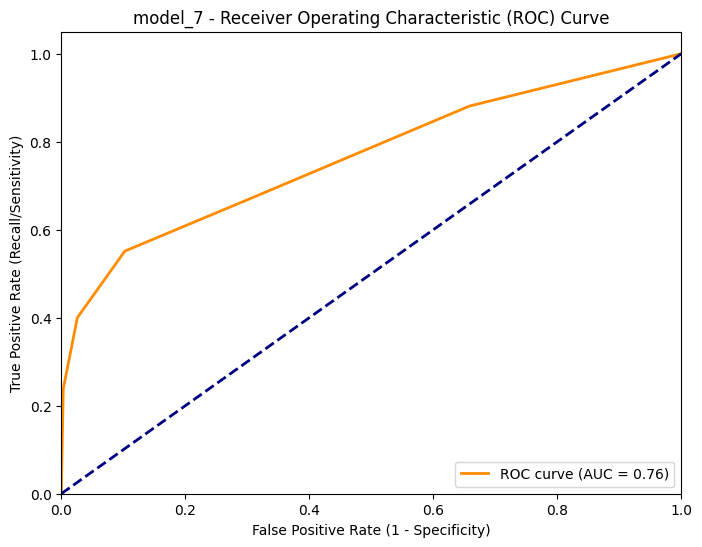

PR-AUC Score: 0.5141


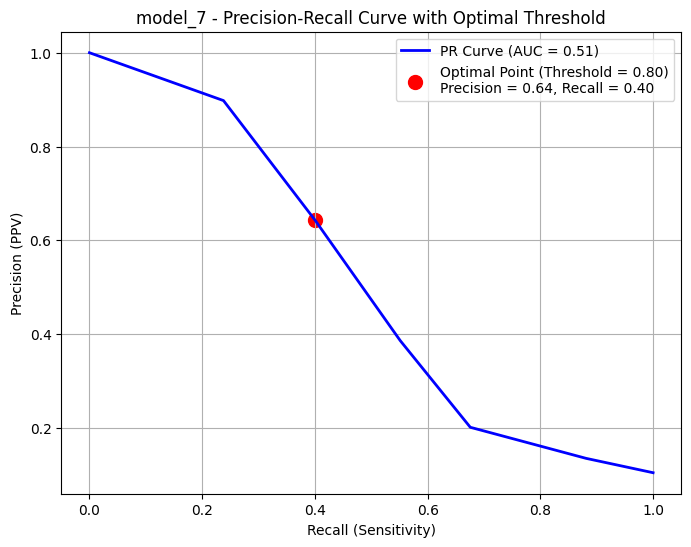


Classification Report at Optimal Threshold (0.80):
              precision    recall  f1-score   support

       Alive       0.93      0.97      0.95      1581
        Died       0.64      0.40      0.49       185

    accuracy                           0.91      1766
   macro avg       0.79      0.69      0.72      1766
weighted avg       0.90      0.91      0.90      1766

Confusion Matrix at Optimal Threshold:
[[1540   41]
 [ 111   74]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9741


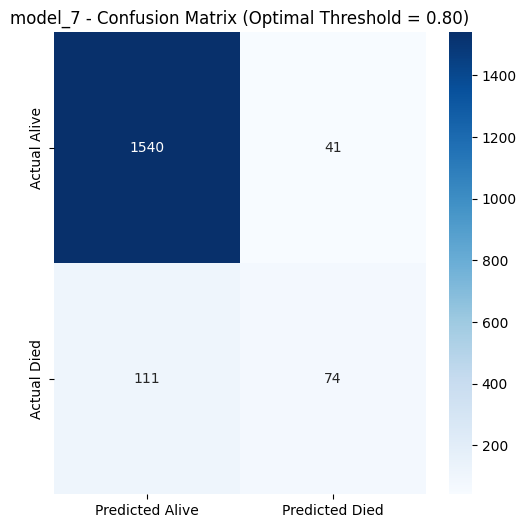

In [ ]:
evaluate_model_performance(y_test, y_us_pred1, y_us_proba1, model_name="model_7")

## Undersampling + RandomizedSearchCV (RS)

**Training**

In [ ]:
param_dist = {
    'kneighborsclassifier__n_neighbors': randint(3, 50),
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__p': [1, 2],
    'randomundersampler__sampling_strategy': [0.5, 0.7, 1.0]
}

In [ ]:

knn_us_rs = RandomizedSearchCV(
    estimator=knn_us,
    param_distributions=param_dist,
    n_iter=30,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=123
)

In [ ]:
knn_us_rs.fit(X_train2, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=123, shuffle=True),
                   estimator=Pipeline(steps=[('randomundersampler',
                                              RandomUnderSampler(random_state=123)),
                                             ('kneighborsclassifier',
                                              KNeighborsClassifier())]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'kneighborsclassifier__n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x79c92c317350>,
                                        'kneighborsclassifier__p': [1, 2],
                                        'kneighborsclassifier__weights': ['uniform',
                                                                          'distance'],
                                        'randomundersampler__sampling_strategy': [0.5,
                                                                                  0.7,
                                                                                  1.0]},
                   random_state=123, scoring='roc_auc')

In [ ]:
# Best model evaluation
print("\nBest parameters:", knn_us_rs.best_params_)
print("Best CV F1 score:", knn_us_rs.best_score_)


Best parameters: {'kneighborsclassifier__n_neighbors': 47, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'uniform', 'randomundersampler__sampling_strategy': 1.0}
Best CV F1 score: 0.7920510359298386


In [ ]:

print("\n--- Final Model Training ---")
best_knn_us_rs = knn_us_rs.best_estimator_
best_knn_us_rs.fit(X_train2, y_train)


--- Final Model Training ---


/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Pipeline(steps=[('randomundersampler',
                 RandomUnderSampler(random_state=123, sampling_strategy=1.0)),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=47, p=1))])

**Prediction**

In [ ]:

y_us_pred2 = best_knn_us_rs.predict(X_test2)
y_us_proba2 = best_knn_us_rs.predict_proba(X_test2)[:, 1]

**Evaluation**


==================== Evaluation for model_8 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.94      0.98      0.96      1581
    Died (1)       0.70      0.48      0.57       185

    accuracy                           0.92      1766
   macro avg       0.82      0.73      0.76      1766
weighted avg       0.92      0.92      0.92      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.9760


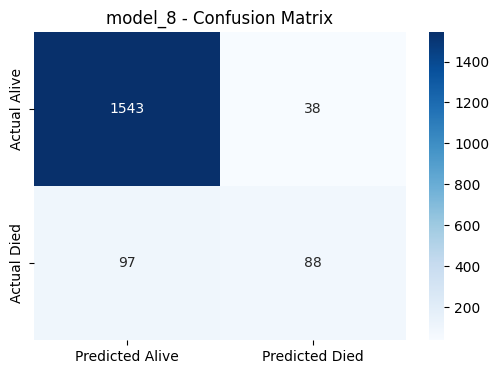


ROC-AUC Score: 0.7816


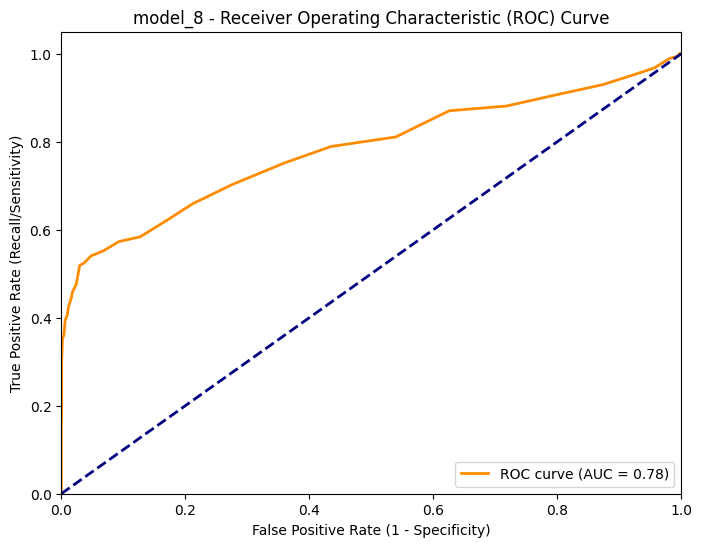

PR-AUC Score: 0.5898


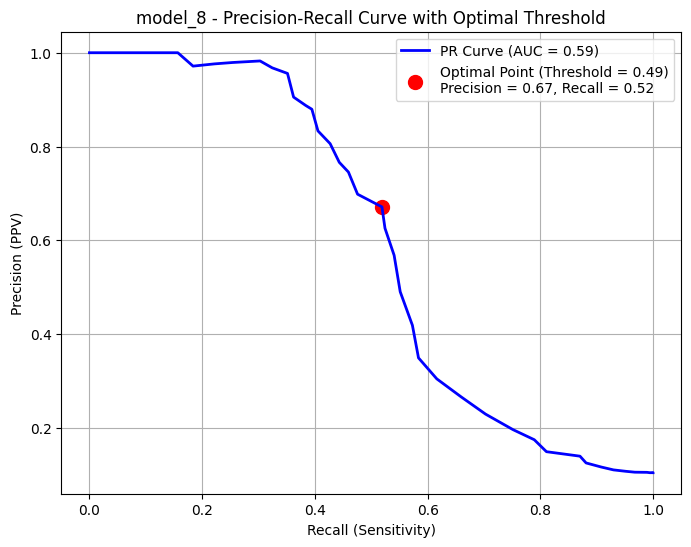


Classification Report at Optimal Threshold (0.49):
              precision    recall  f1-score   support

       Alive       0.95      0.97      0.96      1581
        Died       0.67      0.52      0.59       185

    accuracy                           0.92      1766
   macro avg       0.81      0.74      0.77      1766
weighted avg       0.92      0.92      0.92      1766

Confusion Matrix at Optimal Threshold:
[[1534   47]
 [  89   96]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9703


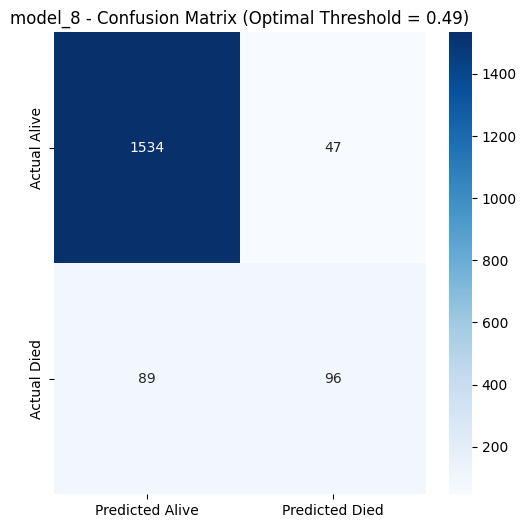

In [ ]:
evaluate_model_performance(y_test, y_us_pred2, y_us_proba2, model_name="model_8")

## Undersampling + GridSearchCV (GS)

**Training**

In [ ]:

param_grid = {
    'randomundersampler__sampling_strategy': [0.7, 0.8, 0.9],
    'kneighborsclassifier__n_neighbors': [5, 7, 9, 11],
    'kneighborsclassifier__weights': ['distance'],
    'kneighborsclassifier__p': [1],
    'kneighborsclassifier__leaf_size': [20, 30]
}

In [ ]:

knn_us_gs = GridSearchCV(
    estimator=knn_us,
    param_grid=param_grid,
    scoring=f1_scorer,
    refit='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

In [ ]:
# Train with full grid search
knn_us_gs.fit(X_train2, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=123, shuffle=True),
             estimator=Pipeline(steps=[('randomundersampler',
                                        RandomUnderSampler(random_state=123)),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__leaf_size': [20, 30],
                         'kneighborsclassifier__n_neighbors': [5, 7, 9, 11],
                         'kneighborsclassifier__p': [1],
                         'kneighborsclassifier__weights': ['distance'],
                         'randomundersampler__sampling_strategy': [0.7, 0.8,
                                                                   0.9]},
             refit='f1',
             scoring=make_scorer(f1_score, response_method='predict', average=binary, pos_label=1),
             verbose=1)

In [ ]:
# Best model evaluation
print("\nBest parameters:", knn_us_gs.best_params_)
print("Best CV F1 score:", knn_us_gs.best_score_)


Best parameters: {'kneighborsclassifier__leaf_size': 20, 'kneighborsclassifier__n_neighbors': 11, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'distance', 'randomundersampler__sampling_strategy': 0.7}
Best CV F1 score: 0.5115566441884142


In [ ]:
best_knn_us_gs = knn_us_gs.best_estimator_
best_knn_us_gs.fit(X_train2, y_train)  # No eval_set here

/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Pipeline(steps=[('randomundersampler',
                 RandomUnderSampler(random_state=123, sampling_strategy=0.7)),
                ('kneighborsclassifier',
                 KNeighborsClassifier(leaf_size=20, n_neighbors=11, p=1,
                                      weights='distance'))])

**Prediction**

In [ ]:

y_us_pred3 = best_knn_us_gs.predict(X_test2)
y_us_proba3 = best_knn_us_gs.predict_proba(X_test2)[:, 1]

**Evaluation**


==================== Evaluation for model_9 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.94      0.96      0.95      1581
    Died (1)       0.58      0.49      0.53       185

    accuracy                           0.91      1766
   macro avg       0.76      0.72      0.74      1766
weighted avg       0.90      0.91      0.91      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.9595


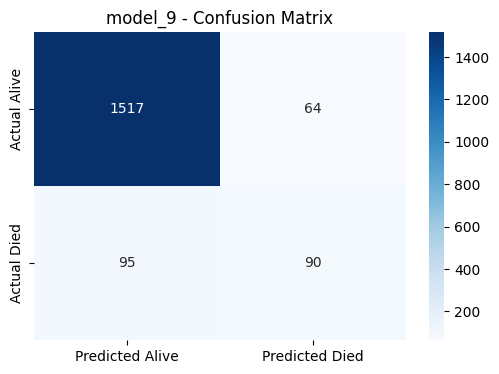


ROC-AUC Score: 0.7585


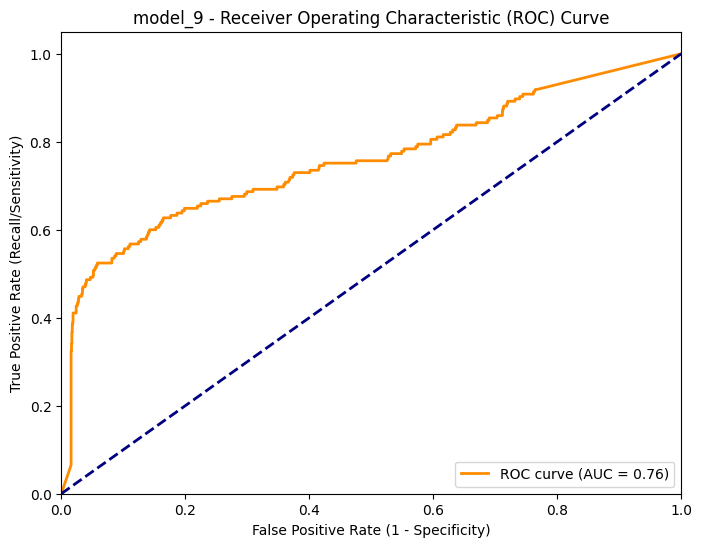

PR-AUC Score: 0.4141


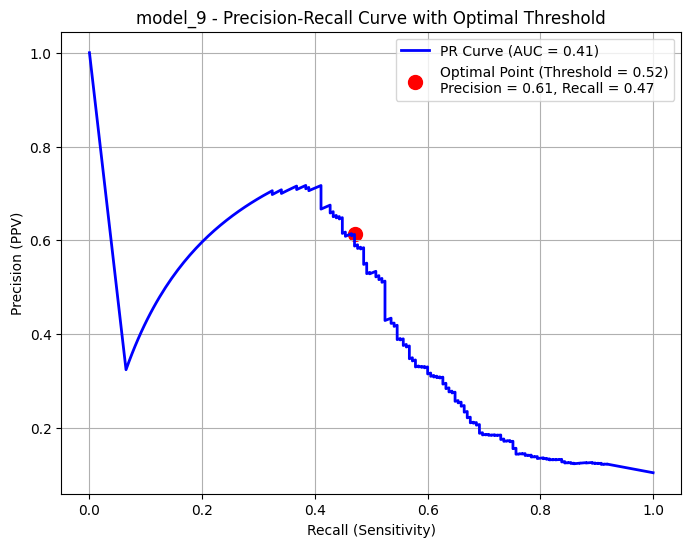


Classification Report at Optimal Threshold (0.52):
              precision    recall  f1-score   support

       Alive       0.94      0.97      0.95      1581
        Died       0.61      0.47      0.53       185

    accuracy                           0.91      1766
   macro avg       0.78      0.72      0.74      1766
weighted avg       0.91      0.91      0.91      1766

Confusion Matrix at Optimal Threshold:
[[1526   55]
 [  98   87]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9652


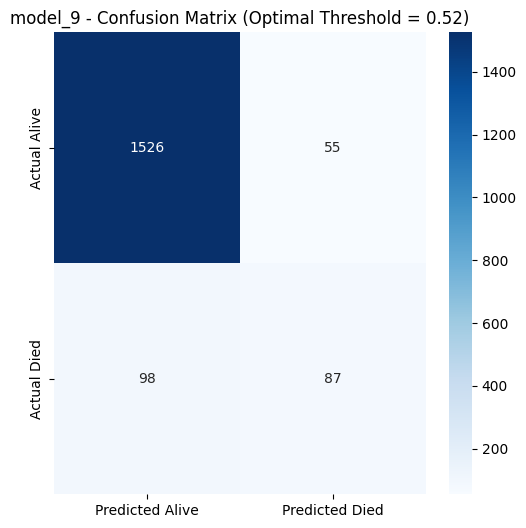

In [ ]:
evaluate_model_performance(y_test, y_us_pred3, y_us_proba3, model_name="model_9")

# Train the model after Balancing using HYBRID RESAMPLING

##Hybrid Only

**Training**

In [ ]:
knn_hy = make_pipeline(
    SMOTE(random_state=123),
    RandomUnderSampler(random_state=123),
    model_1
)

In [ ]:

knn_hy.fit(X_train2, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Pipeline(steps=[('smote', SMOTE(random_state=123)),
                ('randomundersampler', RandomUnderSampler(random_state=123)),
                ('kneighborsclassifier', KNeighborsClassifier())])

**Prediction**

In [ ]:

y_hy_pred1= knn_hy.predict(X_test2)
y_hy_proba1 = knn_hy.predict_proba(X_test2)[:, 1]

**Evaluation**


==================== Evaluation for model_10 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.94      0.90      0.92      1581
    Died (1)       0.39      0.55      0.45       185

    accuracy                           0.86      1766
   macro avg       0.67      0.72      0.69      1766
weighted avg       0.89      0.86      0.87      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.8975


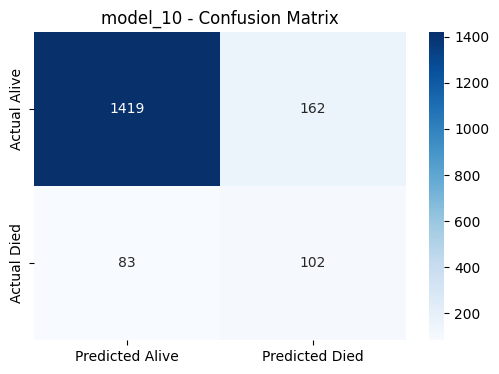


ROC-AUC Score: 0.7633


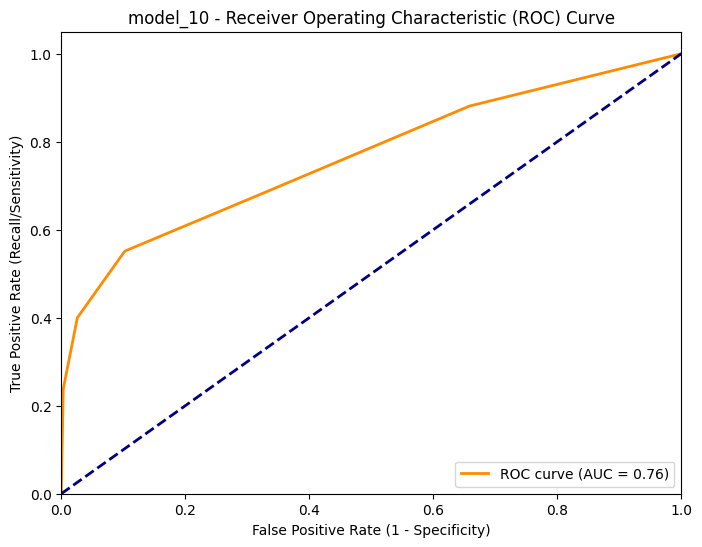

PR-AUC Score: 0.5141


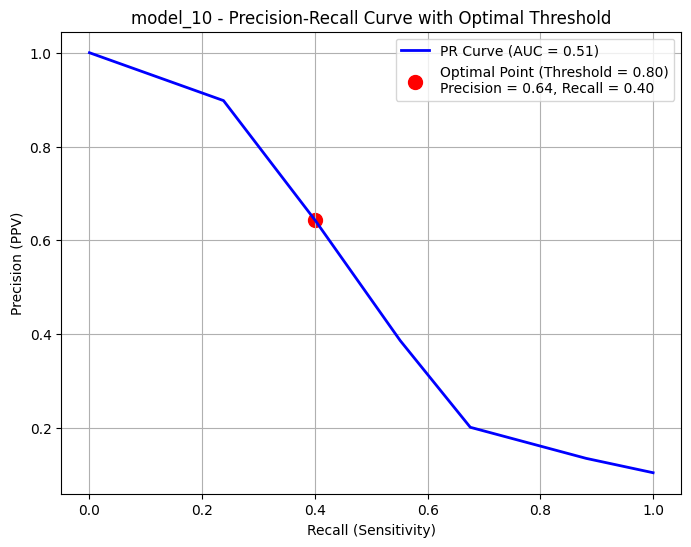


Classification Report at Optimal Threshold (0.80):
              precision    recall  f1-score   support

       Alive       0.93      0.97      0.95      1581
        Died       0.64      0.40      0.49       185

    accuracy                           0.91      1766
   macro avg       0.79      0.69      0.72      1766
weighted avg       0.90      0.91      0.90      1766

Confusion Matrix at Optimal Threshold:
[[1540   41]
 [ 111   74]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9741


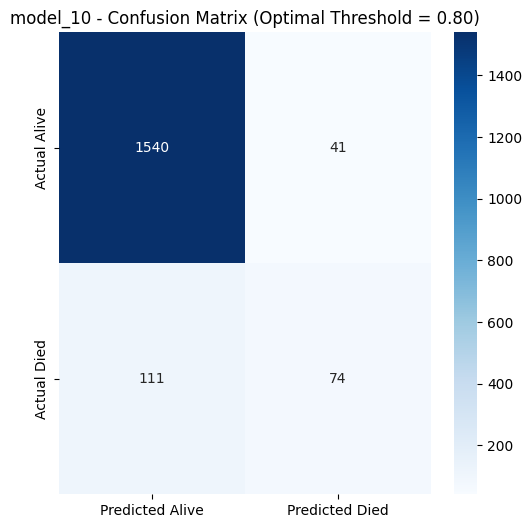

In [ ]:
evaluate_model_performance(y_test, y_us_pred1, y_us_proba1, model_name="model_10")

## Hybrid + RS

**Training**

In [ ]:
param_dist = {
    'smote__sampling_strategy': uniform(0.5, 0.5),
    'randomundersampler__sampling_strategy': uniform(0.5, 0.4),
    'kneighborsclassifier__n_neighbors': randint(3, 25),
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__p': [1, 2],
    'kneighborsclassifier__leaf_size': [20, 30, 40]
}

In [ ]:
knn_hy_rs = RandomizedSearchCV(
    estimator=knn_hy,
    param_distributions=param_dist,
    n_iter=50,
    cv=cv,
    scoring='roc_auc',
    refit=True,
    n_jobs=-1,
    random_state=123,
    verbose=1
)

In [ ]:

knn_hy_rs.fit(X_train2, y_train)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
93 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
93 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/imblearn/pipeline.py", line 514, in fit
    Xt, yt = self._fit(X, y, routed_par

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=123, shuffle=True),
                   estimator=Pipeline(steps=[('smote', SMOTE(random_state=123)),
                                             ('randomundersampler',
                                              RandomUnderSampler(random_state=123)),
                                             ('kneighborsclassifier',
                                              KNeighborsClassifier())]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'kneighborsclassifier__leaf_size': [20,
                                                                            30,
                                                                            40],
                                        'kneighborscla...
                                        'kneighborsclassifier__p': [1, 2],
                                        'kneighborsclassifier__weights': ['uniform',
                                                                          'distance'],
                                        'randomundersampler__sampling_strategy': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x79c92df09bb0>,
                                        'smote__sampling_strategy': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x79c92d004e90>},
                   random_state=123, scoring='roc_auc', verbose=1)

In [ ]:

print("\nBest Params:", knn_hy_rs.best_params_)
print("Best F1 Score (CV):", knn_hy_rs.best_score_)


Best Params: {'kneighborsclassifier__leaf_size': 20, 'kneighborsclassifier__n_neighbors': 23, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'distance', 'randomundersampler__sampling_strategy': np.float64(0.761888522987928), 'smote__sampling_strategy': np.float64(0.6869007134000332)}
Best F1 Score (CV): 0.7668991361899055


In [ ]:
best_knn_hy_rs = knn_hy_rs.best_estimator_
best_knn_hy_rs.fit(X_train2, y_train)  # No eval_set here

/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Pipeline(steps=[('smote',
                 SMOTE(random_state=123,
                       sampling_strategy=np.float64(0.6869007134000332))),
                ('randomundersampler',
                 RandomUnderSampler(random_state=123,
                                    sampling_strategy=np.float64(0.761888522987928))),
                ('kneighborsclassifier',
                 KNeighborsClassifier(leaf_size=20, n_neighbors=23, p=1,
                                      weights='distance'))])

**Prediction**

In [ ]:

y_hy_pred2 = best_knn_hy_rs.predict(X_test2)
y_hy_proba2 = best_knn_hy_rs.predict_proba(X_test2)[:, 1]

**Evaluation**


==================== Evaluation for model_11 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.94      0.89      0.92      1581
    Died (1)       0.37      0.54      0.44       185

    accuracy                           0.86      1766
   macro avg       0.66      0.72      0.68      1766
weighted avg       0.88      0.86      0.87      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.8944


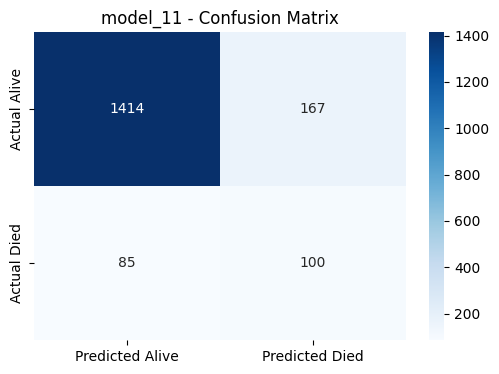


ROC-AUC Score: 0.7566


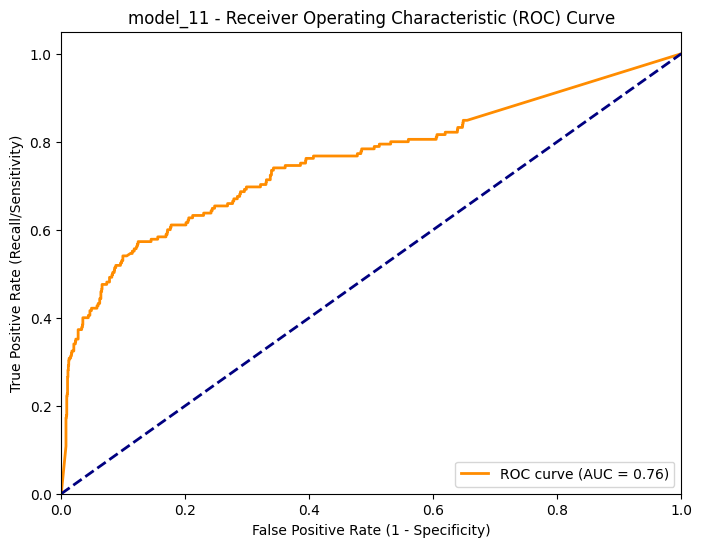

PR-AUC Score: 0.4369


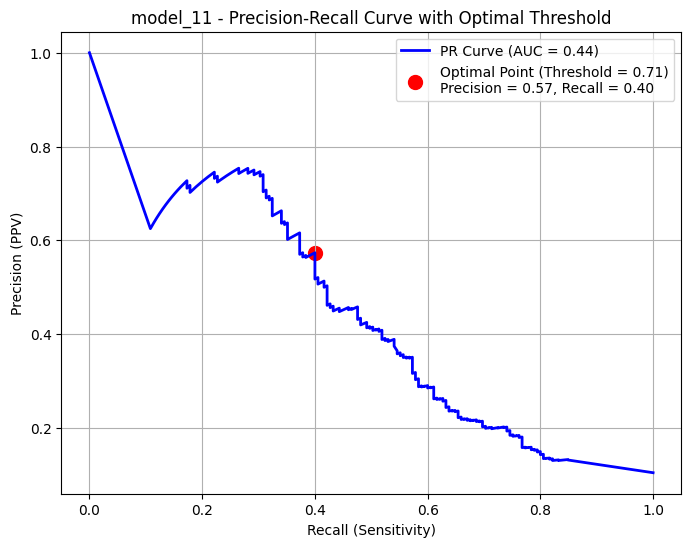


Classification Report at Optimal Threshold (0.71):
              precision    recall  f1-score   support

       Alive       0.93      0.97      0.95      1581
        Died       0.57      0.40      0.47       185

    accuracy                           0.91      1766
   macro avg       0.75      0.68      0.71      1766
weighted avg       0.89      0.91      0.90      1766

Confusion Matrix at Optimal Threshold:
[[1526   55]
 [ 111   74]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9652


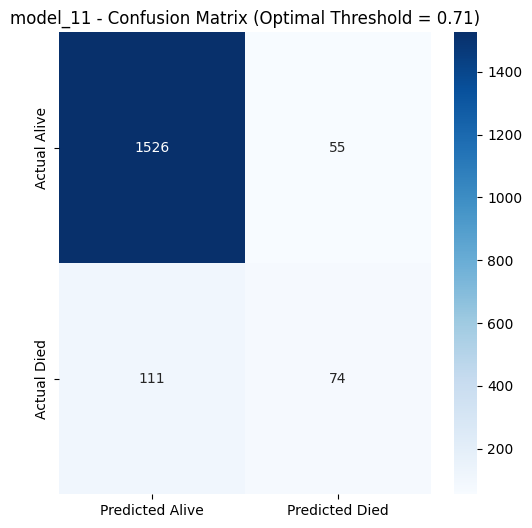

In [ ]:
evaluate_model_performance(y_test, y_hy_pred2, y_hy_proba2, model_name="model_11")

## Hybrid +GS

**Training**

In [ ]:
param_grid = {
    'smote__sampling_strategy': [0.75, 1.0],
    'randomundersampler__sampling_strategy': [0.5, 0.75],
    'kneighborsclassifier__n_neighbors': [5, 7, 9, 11],
    'kneighborsclassifier__weights': ['distance'],
    'kneighborsclassifier__p': [1],
    'kneighborsclassifier__leaf_size': [20, 30]
}

In [ ]:

knn_hy_gs = GridSearchCV(
    estimator=knn_hy,
    param_grid=param_grid,
    scoring='roc_auc',
    refit='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

In [ ]:

knn_hy_gs.fit(X_train2, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
72 fits failed out of a total of 96.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
72 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/imblearn/pipeline.py", line 514, in fit
    Xt, yt = self._fit(X, y, routed_para

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=123, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=123)),
                                       ('randomundersampler',
                                        RandomUnderSampler(random_state=123)),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__leaf_size': [20, 30],
                         'kneighborsclassifier__n_neighbors': [5, 7, 9, 11],
                         'kneighborsclassifier__p': [1],
                         'kneighborsclassifier__weights': ['distance'],
                         'randomundersampler__sampling_strategy': [0.5, 0.75],
                         'smote__sampling_strategy': [0.75, 1.0]},
             refit='roc_auc', scoring='roc_auc', verbose=2)

In [ ]:

print("\nBest Params:", knn_hy_gs.best_params_)
print("Best F1 Score (CV):", knn_hy_gs.best_score_)


Best Params: {'kneighborsclassifier__leaf_size': 20, 'kneighborsclassifier__n_neighbors': 11, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'distance', 'randomundersampler__sampling_strategy': 0.75, 'smote__sampling_strategy': 0.75}
Best F1 Score (CV): 0.7531665115490888


In [ ]:
best_knn_hy_gs = knn_hy_gs.best_estimator_
best_knn_hy_gs.fit(X_train2, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Pipeline(steps=[('smote', SMOTE(random_state=123, sampling_strategy=0.75)),
                ('randomundersampler',
                 RandomUnderSampler(random_state=123, sampling_strategy=0.75)),
                ('kneighborsclassifier',
                 KNeighborsClassifier(leaf_size=20, n_neighbors=11, p=1,
                                      weights='distance'))])

**Prediction**

In [ ]:

y_hy_pred3 = best_knn_hy_gs.predict(X_test2)
y_hy_proba3 = best_knn_hy_gs.predict_proba(X_test2)[:, 1]

**Evaluation**


==================== Evaluation for model_12 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.94      0.90      0.92      1581
    Died (1)       0.37      0.52      0.44       185

    accuracy                           0.86      1766
   macro avg       0.66      0.71      0.68      1766
weighted avg       0.88      0.86      0.87      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.8969


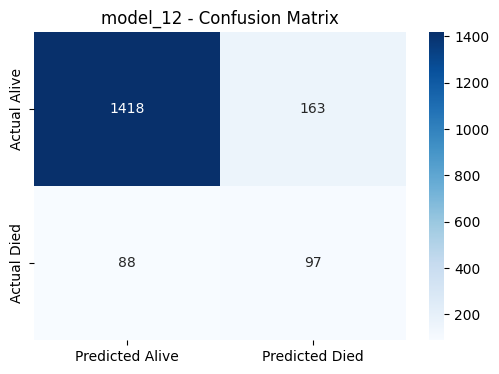


ROC-AUC Score: 0.7562


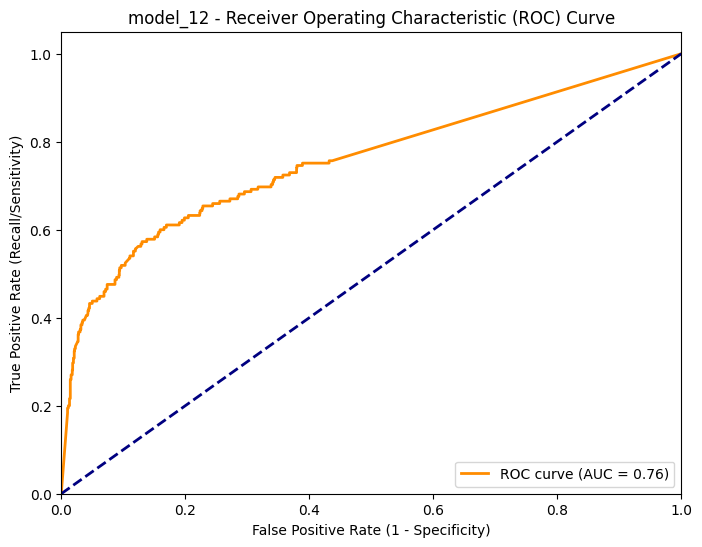

PR-AUC Score: 0.4409


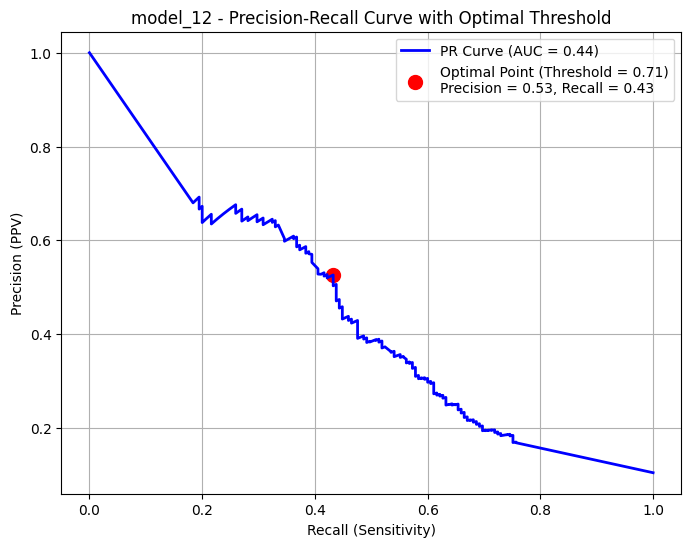


Classification Report at Optimal Threshold (0.71):
              precision    recall  f1-score   support

       Alive       0.93      0.95      0.94      1581
        Died       0.53      0.43      0.47       185

    accuracy                           0.90      1766
   macro avg       0.73      0.69      0.71      1766
weighted avg       0.89      0.90      0.90      1766

Confusion Matrix at Optimal Threshold:
[[1509   72]
 [ 105   80]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9545


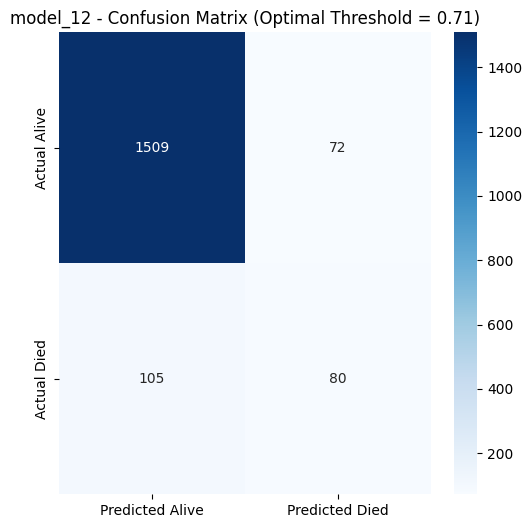

In [ ]:
evaluate_model_performance(y_test, y_hy_pred3, y_hy_proba3, model_name="model_12")

#Overfitting Assessment

Compute training and test accuracy to check for overfitting

In [ ]:
# Predict on training data
y_o_train_pred = best_knn_us_rs.predict(X_train2)
train_accuracy = accuracy_score(y_train, y_o_train_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Predict on test data
y_o_test_pred = best_knn_us_rs.predict(X_test2)
test_accuracy = accuracy_score(y_test, y_o_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Compare: If train >> test, potential overfitting
if train_accuracy - test_accuracy > 0.05:  # Arbitrary threshold; adjust based on domain
    print("Warning: Model may be overfitting (large gap between train and test accuracy).")
else:
    print("Model appears well-generalized.")

Training Accuracy: 0.9245
Test Accuracy: 0.9236
Model appears well-generalized.
